I was really intrigued by watching youtube videos of people making game-playing AI, and I really wanted to learn it. Follow me as I make use of OpenAI's gymnasium library to train a deep reinforcement learning model to balance a pole on a moving cart.

In [1]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]
from IPython.display import clear_output
clear_output()

###Key Concepts in Reinforcement Learning (RL)
1. Agent and Environment: The "agent" is the AI trying to learn, while the "environment" is the task or game it interacts with. For example, in the "CartPole" game, the agent tries to balance a pole on a moving cart.

2. State: This represents the current situation of the environment. It can be a set of values, like the position and angle of the pole.

3. Action: This is a move or choice the agent can make (e.g., moving the cart left or right).

4. Reward: A number given to the agent to indicate how well it is doing. The goal of the agent is to maximize its total reward over time.

5. Q-Value: The "quality" of a specific action in a given state, representing the expected future reward. Higher Q-values indicate better actions. More about this comes later in the notebook.

#Setting Up the Environment

1. What is Gymnasium? It’s a toolkit that helps you create and manage environments for RL. Think of an "environment" as a game or task that an AI (or agent) will learn to complete.

2. Choosing an Environment: Gymnasium has various environments (e.g., CartPole, MountainCar). Each one represents a different problem for the agent to solve, like balancing a pole or climbing a hill.

Imports -
gymnasium: Contains the prebuilt environments (e.g., CartPole).

numpy: For numerical operations.

random: Helps with action exploration.

torch: PyTorch library for building and training the neural network.

deque: Efficiently stores past experiences for replaying during training.

In [2]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Example environment setup
env = gym.make('CartPole-v1')  # Set render_mode to "human" for real-time rendering

Using device: cuda


##Hyperparameters
GAMMA = 0.99: Gamma is the discount factor, controlling how much the agent
cares about future rewards versus immediate rewards. A value close to 1 means it values long-term rewards.

LEARNING_RATE = 0.001: This rate tells the optimizer how much to adjust the neural network’s weights with each step. Small changes (e.g., 0.001) are typical for stability.

BATCH_SIZE = 64: When training the network, it learns from a group of experiences, called a "batch," which in this case contains 64 experiences.

REPLAY_BUFFER_SIZE = 10000: This is the maximum number of experiences stored in memory. Old experiences are discarded when the buffer is full.

TARGET_UPDATE_FREQ = 10: The "target network" (a stable copy of our network used for learning) is updated every 10 episodes to prevent rapid changes.

EPSILON_START = 1.0: Epsilon controls how much the agent explores randomly. It starts at 1 (fully random).

EPSILON_MIN = 0.01: Epsilon’s minimum value. The agent will always explore a tiny bit, even after learning.

EPSILON_DECAY = 0.995: Epsilon decreases by multiplying by this value each episode, moving gradually from exploration to exploitation.

NUM_EPISODES = 500: The total number of episodes the agent will train.

MAX_STEPS = 200: The maximum steps the agent takes within an episode before it stops.

In [3]:
# Hyperparameters
GAMMA = 0.99             # Discount factor for future rewards
LEARNING_RATE = 0.001    # Learning rate for the optimizer
BATCH_SIZE = 64          # Number of experiences sampled for each training step
REPLAY_BUFFER_SIZE = 10000 # Max size of the replay buffer
TARGET_UPDATE_FREQ = 10  # How often to update the target network
EPSILON_START = 1.0      # Initial exploration rate
EPSILON_MIN = 0.01       # Minimum exploration rate
EPSILON_DECAY = 0.995    # Rate of decay for exploration rate
NUM_EPISODES = 500       # Total number of training episodes
MAX_STEPS = 200          # Max steps per episode


#Understanding the Environment
1. Observation Space: The environment gives observations, which describe the state of the task. For example, in CartPole, observations include the cart’s position, the pole’s angle, etc.

2. Action Space: This is the set of possible actions the agent can take, like moving left or right. The agent will pick actions based on what it "sees" in the observation space.

In [4]:
# Get observation and action spaces
print(env.observation_space)  # Example: position and velocity of CartPole
print(env.action_space)       # Example: moving left or right

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Discrete(2)


#Defining the Agent
1. Agent’s Goal: The agent’s goal is to maximize a reward. It learns to take actions that increase its reward over time. This is where deep learning comes in—usually, a neural network decides which actions to take. In simpler environments, a Q-table is used, where all the possible states have a Q value. It could be used here as well, but I want to overkill. Here is the formula for calculating those taken straight from Wikipedia (https://en.wikipedia.org/wiki/Q-learning) -

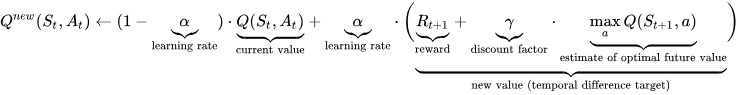


2. Neural Network: The neural network takes in the observation as input and outputs a probability or value for each action. With enough training, it "learns" which actions work best in different situations.

###Define the Q-Network
The Q-Network takes the current state as input and outputs Q-values for each action.

fc1, fc2, fc3: Three fully connected layers with ReLU activations between them. The final layer outputs a value for each action (e.g., left or right for CartPole).

1. class QNetwork(nn.Module):: We define a neural network class called QNetwork, inheriting from nn.Module (a PyTorch base class for models).

2. def __init__(self, state_dim, action_dim):: This constructor method initializes the network with inputs for the state and action sizes.

3. state_dim: The number of values that represent the state (e.g., position and velocity in CartPole).
action_dim: The number of possible actions (e.g., left or right for CartPole).
super(QNetwork, self).__init__(): Calls the parent __init__ method from nn.Module.

4. Network Layers:

* self.fc1 = nn.Linear(state_dim, 128): The first fully connected (fc) layer, which takes in the state and outputs 128 values. nn.Linear creates a layer with weights for learning.

* self.fc2 = nn.Linear(128, 64): The second layer, taking 128 inputs from the
previous layer and outputting 64.

* self.fc3 = nn.Linear(64, action_dim): The final layer outputs values equal to the number of actions, representing the Q-values for each action.

5. def forward(self, x):: This function processes the input through the network.

* x = torch.relu(self.fc1(x)): The input goes through fc1 and then relu, an activation function that adds non-linearity, allowing the network to learn complex patterns.

* x = torch.relu(self.fc2(x)): Passes through fc2 and relu.

* return self.fc3(x): The final layer outputs Q-values for each action.

In [12]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

### Define the Experience Replay Buffer
The ReplayBuffer stores past experiences (state, action, reward, next_state, done), which helps in stabilizing training by breaking correlations.

1. class ReplayBuffer:: This is a class definition for the replay buffer.

2. def __init__(self, capacity):: The __init__ function initializes the buffer with a fixed capacity, the maximum number of experiences it can hold.

* self.buffer = deque(maxlen=capacity): deque is a data structure that works like a list but is optimized for fast addition/removal at both ends. Setting maxlen means that once the buffer reaches the capacity limit, the oldest experience will automatically be removed.
3. def push(self, experience):: This function adds an experience to the buffer.

* self.buffer.append(experience): Appends a new experience to buffer. An experience is a tuple containing the state, action, reward, next state, and done flag (indicating if the episode has ended).
4. def sample(self, batch_size):: This function randomly samples a batch of experiences from the buffer.

* return random.sample(self.buffer, batch_size): The random.sample function picks batch_size elements randomly, helping the agent to learn from diverse past experiences.
5. def __len__(self):: This function returns the number of items in the buffer.

* return len(self.buffer): Allows us to check if the buffer has enough experiences to train the model (at least BATCH_SIZE items).

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

#Training the Agent with Deep RL
1. Exploration vs. Exploitation: At first, the agent explores by trying random actions to gather information. Over time, it begins to exploit its knowledge by picking actions that give high rewards.

2. Rewards and Learning: The agent learns by updating the network based on rewards. Algorithms like Q-learning, DQN, and PPO are used to adjust the network to predict or maximize future rewards.

###Select Action Using an Epsilon-Greedy Policy
The agent chooses actions using an epsilon-greedy policy: with probability epsilon, it picks a random action (exploration); otherwise, it picks the best-known action (exploitation).

In [15]:
def select_action(state, policy_net, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        with torch.no_grad():
            return policy_net(state).argmax().item()  # Exploit


1. def select_action(state, policy_net, epsilon):: This function decides which action the agent should take based on the current state, the neural network (policy_net), and the exploration rate epsilon.

2. if random.random() < epsilon:: random.random() generates a random number between 0 and 1. If it’s less than epsilon, the agent will explore (choose a random action).

3. return env.action_space.sample(): Calls the environment’s sample() function to pick a random action from the available actions.
else:: If random.random() is not less than epsilon, the agent will exploit, choosing the action that gives the highest Q-value according to policy_net.

4. with torch.no_grad():: Temporarily turns off gradient tracking in PyTorch, saving memory and computation. This is because we don’t need to update the network during action selection.

5. return policy_net(torch.tensor(state, dtype=torch.float32)).argmax().item(): Converts state to a tensor and feeds it into policy_net. The network outputs Q-values for all actions, and argmax() picks the action with the highest Q-value.

###Optimize the model
This function updates the neural network based on a batch of experiences, adjusting weights to minimize the error between predicted and actual Q-values. This process is called backpropagation.

MSE Loss: Measures the difference between the expected Q-values and the predicted Q-values.

Optimizer Step: Updates the neural network weights to minimize the loss.

In [16]:
def optimize_model():
    if len(replay_buffer) < BATCH_SIZE:
        return

    # Sample a batch and convert lists of arrays to numpy arrays for efficient tensor conversion
    batch = replay_buffer.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = map(np.array, zip(*batch))  # Converts each to a numpy array

    # Convert numpy arrays to PyTorch tensors and move to device
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Calculate Q values and optimize
    current_q_values = policy_net(states).gather(1, actions).squeeze()
    next_q_values = target_net(next_states).max(1)[0]
    expected_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def optimize_model():: This function optimizes (or trains) the neural network using a sample of experiences.

if len(replay_buffer) < BATCH_SIZE:: Checks if there are enough experiences in the replay_buffer for training. If not, it returns without training.

batch = replay_buffer.sample(BATCH_SIZE): Gets a random batch of experiences from the buffer.

states, actions, rewards, next_states, dones = zip(*batch): Unpacks the batch into separate lists for states, actions, rewards, next_states, and dones.

Convert to PyTorch tensors: Converts each list into a tensor format PyTorch can process.

.unsqueeze(1): Adds an extra dimension to actions to match PyTorch’s expected input shape.
Calculate the Q values:

current_q_values = policy_net(states).gather(1, actions).squeeze(): Predicts Q-values for the states and selects Q-values for the specific actions taken by the agent. .squeeze() removes unnecessary dimensions.

next_q_values = target_net(next_states).max(1)[0]: Uses the target_net to predict the Q-values for next_states and picks the maximum value (best action in the next state).

expected_q_values = rewards + (GAMMA * next_q_values * (1 - dones)): This is the Bellman equation. It calculates the expected Q-value by adding the reward to the discounted (GAMMA) future Q-value of the next state. The term (1 - dones) ensures that if the episode is over, the future Q-value is zero.

Calculate loss and optimize:

loss = nn.MSELoss()(current_q_values, expected_q_values): Measures the difference between the predicted Q-values and the expected Q-values using Mean Squared Error (MSE), which calculates the average of the squared differences.

optimizer.zero_grad(): Clears any previous gradients, resetting them before backpropagation.

loss.backward(): Calculates the gradients (partial derivatives) of the loss with respect to each weight in the network.

optimizer.step(): Updates the weights in the neural network to minimize the loss, moving closer to the expected Q-values.



###Training Loop
1. Environment Reset: The environment is reset at the beginning of each episode.
2. Action Selection: Choose an action based on the current state and epsilon-greedy policy.
3. Step Through Environment: Take the action, observe the next state, reward, and done signal (if the episode is over).
4. Store Experience: Add the experience tuple to the replay buffer.
5. Optimize Model: If enough experiences are in the replay buffer, sample a batch and train the model.
6. Epsilon Decay: Reduce exploration over time as the agent learns.
7. Target Network Update: Periodically update the target network with the policy network’s weights.

In [17]:
#env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = QNetwork(state_dim, action_dim).to(device)
target_net = QNetwork(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())  # Copy weights from policy network
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)

epsilon = EPSILON_START

for episode in range(NUM_EPISODES):
    state = torch.tensor(env.reset()[0], dtype=torch.float32).to(device)
    total_reward = 0

    for t in range(MAX_STEPS):
        action = select_action(state, policy_net, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)

        # Push experience to replay buffer (as numpy for CPU storage)
        replay_buffer.push((state.cpu().numpy(), action, reward, next_state.cpu().numpy(), done))
        state = next_state
        total_reward += reward

        optimize_model()  # Train the network

        if done:
            break

    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    if episode % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

env.close()

Episode 1: Total Reward = 26.0
Episode 2: Total Reward = 24.0
Episode 3: Total Reward = 18.0
Episode 4: Total Reward = 14.0
Episode 5: Total Reward = 13.0
Episode 6: Total Reward = 13.0
Episode 7: Total Reward = 47.0
Episode 8: Total Reward = 19.0
Episode 9: Total Reward = 18.0
Episode 10: Total Reward = 19.0
Episode 11: Total Reward = 13.0
Episode 12: Total Reward = 31.0
Episode 13: Total Reward = 20.0
Episode 14: Total Reward = 20.0
Episode 15: Total Reward = 17.0
Episode 16: Total Reward = 11.0
Episode 17: Total Reward = 17.0
Episode 18: Total Reward = 28.0
Episode 19: Total Reward = 12.0
Episode 20: Total Reward = 21.0
Episode 21: Total Reward = 15.0
Episode 22: Total Reward = 60.0
Episode 23: Total Reward = 22.0
Episode 24: Total Reward = 15.0
Episode 25: Total Reward = 9.0
Episode 26: Total Reward = 19.0
Episode 27: Total Reward = 16.0
Episode 28: Total Reward = 60.0
Episode 29: Total Reward = 24.0
Episode 30: Total Reward = 57.0
Episode 31: Total Reward = 21.0
Episode 32: Total 

In [18]:
# Save the policy network
torch.save(policy_net.state_dict(), "cartpole_policy_net.pth")

from google.colab import files

# Download the file to your local machine
files.download("cartpole_policy_net.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>